### 📊 **Informe: Modelo de Clasificación de Género de Películas**

### 👥 Integrantes
- Miguel Mateo Sandoval Torres  
- Diego Dayan Niño Pérez  
- Camilo Andrés Flórez Esquivel  
- Andrea Amariles Escobar  

### 📚 Curso
**Machine Learning y Procesamiento de Lenguaje Natural**

### 🗓️ Fecha
**Mayo de 2025**

### **Introducción** <br>
<p style="text-align: justify;">
Este informe presenta el desarrollo de un modelo de aprendizaje automático, cuyo objetivo es predecir la probabilidad de que una película pertenezca a un género en particular. A lo largo del documento se describen las etapas fundamentales del proceso, incluyendo el preprocesamiento de datos, la selección y calibración del modelo, el entrenamiento y evaluación del rendimiento del mismo, al igual que métricas comparativas con versiones alternativas, con el objetivo de evidenciar el proceso de selección del modelo final. Finalmente, se presenta el procedimiento de disponibilización del modelo predictivo mediante una API.<p>

In [1]:
# Importación librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
import ast
from itertools import chain
from collections import Counter
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
# Recursos
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    WordNetLemmatizer().lemmatize('test')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.word_tokenize("example")
except LookupError:
    nltk.download('punkt')
    nltk.download('punkt_tab')

### **Carga y Preprocesamiento de Datos**

In [ ]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

# Visualización datos de entrenamiento
dataTraining.head()

# Visualización datos de test
dataTesting.head()

In [ ]:
# Revisión general de los datos
nulos = dataTraining.isnull().sum()               # Busqueda de valores nulos
duplicados = dataTraining.duplicated().sum()      # Busqueda de valores repetidos
titulos_unicos = dataTraining['title'].nunique()  # Títulos únicos de películas
dataTraining.info()                               # Información general de los datos

print(f'Valores nulos:\n{nulos}')
print(f'\nValores duplicados: {duplicados}')
print(f'\nCantidad de títulos únicos: {titulos_unicos}')

In [ ]:
# Conversión de la columna 'genres' de string a lista
dataTraining['genres_list'] = dataTraining['genres'].apply(ast.literal_eval)

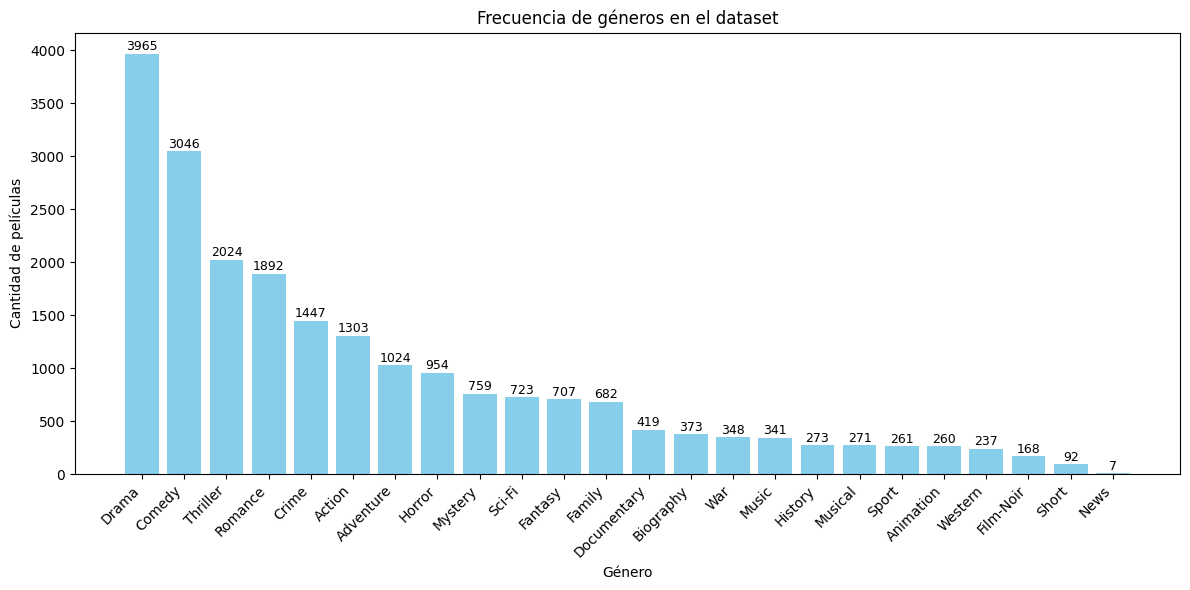

In [5]:
# Visualización de películas por género
frecuencia_generos = list(chain.from_iterable(dataTraining['genres_list']))
conteo_generos = Counter(frecuencia_generos)

sorted_genres = conteo_generos.most_common()
genres, counts = zip(*sorted_genres)

plt.figure(figsize=(12, 6))
bars = plt.bar(genres, counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Género')
plt.ylabel('Cantidad de películas')
plt.title('Frecuencia de géneros en el dataset')
plt.tight_layout()

# Paso 5: Añadir etiquetas a cada barra
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
             str(count), ha='center', va='bottom', fontsize=9)

plt.show()

#### Definición de Funciones de Preprocesamiento

In [ ]:
# Inicialización de herramientas
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Función de preprocesamiento
def preprocess_text_1(text):
    if isinstance(text, str): # Verificar si entrada es string
        text = text.lower()
        text = re.sub(r'[^a-z\s]', '', text) # Eliminar caracteres no alfabéticos
        tokens = nltk.word_tokenize(text) # Tokenización
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2] # Lematización y eliminación de stopwords y palabras cortas
        return ' '.join(tokens)
    return ''

### **Entrenamiento y Selección del Modelo**

Se entrenaron y calibraron diferentes modelos predictivos. A continuación se presentan tres modelos a partir de los cuales se eligió el que presentó el mejor desempeño:

#### Modelo 1: Regresión Logística con NLTK y CountVectorizer

In [ ]:

dataTraining['plot_clean_1'] = dataTraining['plot'].apply(preprocess_text_1)
dataTesting['plot_clean_1'] = dataTesting['plot'].apply(preprocess_text_1)

vect = CountVectorizer(max_features=1000)
X_dtm_1 = vect.fit_transform(dataTraining['plot_clean_1'])
X_dtm_1.shape

# Codificación de etiquetas de salida (géneros)
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))  # convertir a lista
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

KeyError: 'plot_clean_1'

In [ ]:
# División en entrenamiento y prueba
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm_1, y_genres, test_size=0.33, random_state=42)

# Clasificador con Random Forest y One-vs-Rest
clf = OneVsRestClassifier(LogisticRegression(n_jobs=-1, max_iter=1000, random_state=42))
clf.fit(X_train, y_train_genres)

# Predicción
y_pred_genres = clf.predict_proba(X_test)

# Evaluación
roc_auc_score(y_test_genres, y_pred_genres, average='macro')